# A walk through latent space with Stable Diffusion

해당 내용은 케라스 공식 홈페이지의 code example로 제공되는 stable diffusion 예제입니다
https://keras.io/examples/generative/random_walks_with_stable_diffusion/

잠재 공간에 특징이 어떻게 학습이 되었고, 표현되는지, 프롬프트를 섞어 사용하면서 살펴보는 예제입니다! 설명도 재밌게 잘 되어있어, 읽어보시면 좋겠습니다:D
하지만 시간이 촉박한 경우라면 노드의 설명을, 혹은 영어가 어렵다면 성능좋은 번역 인공지능 deepL (https://www.deepl.com/translator) 을 확인하시는 걸 추천드릴게요!

다만, 라이브러리 호환성이 제작 당시와 지금이 맞지 않아, 진행이 원활하지 않을 수 있으며, 특히 코랩 환경의 경우 렉이 발생할 수 있음을 유의해주세요!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_PATH = './drive/MyDrive/Colab\ Notebooks/aiffel/outputs/'

## Overview

Generative image models learn a "latent manifold" of the visual world:
a low-dimensional vector space where each point maps to an image.
Going from such a point on the manifold back to a displayable image
is called "decoding" -- in the Stable Diffusion model, this is handled by
the "decoder" model.

![The Stable Diffusion architecture](https://i.imgur.com/2uC8rYJ.png)

This latent manifold of images is continuous and interpolative, meaning that:

1. Moving a little on the manifold only changes the corresponding image a little (continuity).
2. For any two points A and B on the manifold (i.e. any two images), it is possible
to move from A to B via a path where each intermediate point is also on the manifold (i.e.
is also a valid image). Intermediate points would be called "interpolations" between
the two starting images.

Stable Diffusion isn't just an image model, though, it's also a natural language model.
It has two latent spaces: the image representation space learned by the
encoder used during training, and the prompt latent space
which is learned using a combination of pretraining and training-time
fine-tuning.

_Latent space walking_, or _latent space exploration_, is the process of
sampling a point in latent space and incrementally changing the latent
representation. Its most common application is generating animations
where each sampled point is fed to the decoder and is stored as a
frame in the final animation.
For high-quality latent representations, this produces coherent-looking
animations. These animations can provide insight into the feature map of the
latent space, and can ultimately lead to improvements in the training
process. One such GIF is displayed below:

![Panda to Plane](https://keras.io/img/examples/generative/random_walks_with_stable_diffusion/panda2plane.gif)

In this guide, we will show how to take advantage of the Stable Diffusion API
in KerasCV to perform prompt interpolation and circular walks through
Stable Diffusion's visual latent manifold, as well as through
the text encoder's latent manifold.

This guide assumes the reader has a
high-level understanding of Stable Diffusion.
If you haven't already, you should start
by reading the [Stable Diffusion Tutorial](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/).

To start, we import KerasCV and load up a Stable Diffusion model using the
optimizations discussed in the tutorial
[Generate images with Stable Diffusion](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/).
Note that if you are running with a M1 Mac GPU you should not enable mixed precision.

## 총 학습은 두시간 가량 소요됩니다!
#### 지정된 하이퍼 파라메터가 긴 학습시간을 요구하므로,
#### 스탭 수와 배치 수, 이미지 생성 갯수 (예)그리드 사이즈) 등을 줄여 학습하시길 권장합니다!
#### 또한, 코랩 프로 구독과 무료버전의 RAM GPU CPU는 차이가 없는 점도 알고 진행하시면 좋을 것 같습니다 😎

In [ ]:
!nvidia-smi

Tue Sep 19 06:34:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow keras_cv keras_core --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.9/944.9 kB 12.3 MB/s eta 0:00:00


In [ ]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from PIL import Image

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

Using TensorFlow backend
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


## Interpolating between text prompts

In Stable Diffusion, a text prompt is first encoded into a vector,
and that encoding is used to guide the diffusion process.
The latent encoding vector has shape
77x768 (that's huge!), and when we give Stable Diffusion a text prompt, we're
generating images from just one such point on the latent manifold.

To explore more of this manifold, we can interpolate between two text encodings
and generate images at those interpolated points:

In [ ]:
prompt_1 = "A banana"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
interpolation_steps = 5

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding_1.shape}")

492466864/492466864 [==============================] - 14s 0us/step
Encoding shape: (77, 768)


Once we've interpolated the encodings, we can generate images from each point.
Note that in order to maintain some stability between the resulting images we
keep the diffusion noise constant between images.

In [ ]:
seed = 12345

# 수정된 부분입니다
# 최근 변경된 텐서플로 연산 라이브러리(ops) 에서 다른 자료형을 가진 텐서끼리의 연산에 제약사항이 생긴것으로 추적되니, 형변환을 거친 후에 실습을 진행해주세요!
#noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed)
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed, dtype=tf.dtypes.float16)

images = model.generate_image(
    interpolated_encodings,
    batch_size=interpolation_steps,
    diffusion_noise=noise,
)

#코랩환경에서 13분정도 소요됩니다!

198180272/198180272 [==============================] - 1s 0us/step


Now that we've generated some interpolated images, let's take a look at them!

Throughout this tutorial, we're going to export sequences of images as gifs so
that they can be easily viewed with some temporal context. For sequences of
images where the first and last images don't match conceptually, we rubber-band
the gif.

If you're running in Colab, you can view your own GIFs by running:

```
from IPython.display import Image as IImage
IImage("doggo-and-fruit-5.gif")
```

In [ ]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

export_as_gif(
    "doggo-and-fruit-5.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True,
)

![Dog to Fruit 5](https://i.imgur.com/4ZCxZY4.gif)

The results may seem surprising. Generally, interpolating between prompts
produces coherent looking images, and often demonstrates a progressive concept
shift between the contents of the two prompts. This is indicative of a high
quality representation space, that closely mirrors the natural structure
of the visual world.

To best visualize this, we should do a much more fine-grained interpolation,
using hundreds of steps. In order to keep batch size small (so that we don't
OOM our GPU), this requires manually batching our interpolated
encodings.

이 블럭은 25분 정도 소요됩니다!
배치의 크기를 줄여서 테스트해보길 추천드릴게요!
노트북의 파일은 기존의 결과물로, 새로 테스트하는 결과물과 배치 크기에 따른 결과를 비교해보는 것도 좋은 실험이겠네요 😀

In [ ]:
interpolation_steps = 150
batch_size = 2
batches = interpolation_steps // batch_size

# 여기서의 스탭은 상당히 깁니다! 그대로 사용 시 코드 전체 실행 시 2시간 가량 소요
# 스태이블 디퓨전이 일반적으로 필요한 스탭 수를 고려해서, 적당히 조절해보세요~

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("doggo-and-fruit-150.gif", images, rubber_band=True)

#150 스탭 25분 소요됩니다!

25/25 [==============================] - 11s 426ms/step


![Dog to Fruit 150](https://keras.io/img/examples/generative/random_walks_with_stable_diffusion/dog2fruit150.gif)

The resulting gif shows a much clearer and more coherent shift between the two
prompts. Try out some prompts of your own and experiment!

We can even extend this concept for more than one image. For example, we can
interpolate between four prompts:

 스크롤을 내려 결과를 먼저 확인해볼까요?
 grid수를 줄이면 시간이 단축 될 것 같습니다!
 뒤에 학습이 더 남은 만큼, 여러분들은 그리드 수를 줄여
 결과물을 확인해보시기 바랍니다


In [ ]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

interpolation_steps = 6
batch_size = 2
batches = (interpolation_steps**2) // batch_size

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))
encoding_3 = tf.squeeze(model.encode_text(prompt_3))
encoding_4 = tf.squeeze(model.encode_text(prompt_4))

interpolated_encodings = tf.linspace(
    tf.linspace(encoding_1, encoding_2, interpolation_steps),
    tf.linspace(encoding_3, encoding_4, interpolation_steps),
    interpolation_steps,
)
interpolated_encodings = tf.reshape(
    interpolated_encodings, (interpolation_steps**2, 77, 768)
)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images.append(
        model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            diffusion_noise=noise,
        )
    )


def plot_grid(
    images,
    path,
    grid_size,
    scale=2,
):
    fig = plt.figure(figsize=(grid_size * scale, grid_size * scale))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.axis("off")
    images = images.astype(int)
    for row in range(grid_size):
        for col in range(grid_size):
            index = row * grid_size + col
            plt.subplot(grid_size, grid_size, index + 1)
            plt.imshow(images[index].astype("uint8"))
            plt.axis("off")
            plt.margins(x=0, y=0)
    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )

#6BY6 기준 6분가량 소요!

50/50 [==============================] - 21s 426ms/step


<ipython-input-8-091c12e8f2e6>:51: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(grid_size, grid_size, index + 1)


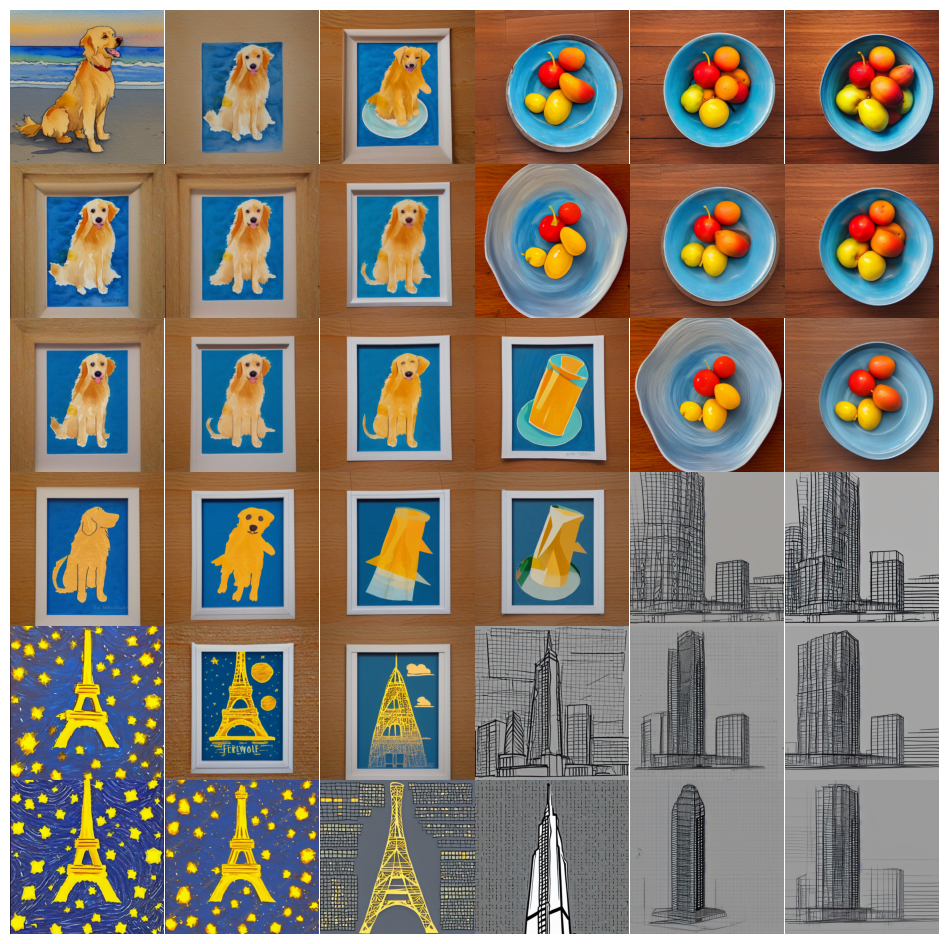

In [ ]:
images = np.concatenate(images)
plot_grid(images, "4-way-interpolation.jpg", interpolation_steps)

We can also interpolate while allowing diffusion noise to vary by dropping
the `diffusion_noise` parameter:

In [ ]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

interpolation_steps = 6
batch_size = 2
batches = (interpolation_steps**2) // batch_size

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))
encoding_3 = tf.squeeze(model.encode_text(prompt_3))
encoding_4 = tf.squeeze(model.encode_text(prompt_4))

interpolated_encodings = tf.linspace(
    tf.linspace(encoding_1, encoding_2, interpolation_steps),
    tf.linspace(encoding_3, encoding_4, interpolation_steps),
    interpolation_steps,
)
interpolated_encodings = tf.reshape(
    interpolated_encodings, (interpolation_steps**2, 77, 768)
)
batched_encodings = tf.split(interpolated_encodings, batches)

In [ ]:
# 해당 셀의 내용은 위에 설명했던 형변환의 문제로 동작하지 않습니다! (2023.09.17)

#images = []
#for batch in range(batches):
#수정코드#  images.append(model.generate_image(tf.cast(batched_encodings[batch],tf.dtypes.float32), batch_size=batch_size))
#원코드#    images.append(model.generate_image(batched_encodings[batch]), batch_size=batch_size))
#images = np.concatenate(images)
#plot_grid(images, "4-way-interpolation-varying-noise.jpg", interpolation_steps)

Next up -- let's go for some walks!

## A walk around a text prompt

Our next experiment will be to go for a walk around the latent manifold
starting from a point produced by a particular prompt.

이 블럭은 15분 정도 소요됩니다!
배치의 크기를 줄여서 테스트해보길 추천드릴게요!
노트북의 파일은 기존의 결과물로, 새로 테스트하는 결과물과 배치 크기에 따른 결과를 비교해보는 것도 좋은 실험이겠네요 😀

In [ ]:
walk_steps = 150
batch_size = 2
batches = walk_steps // batch_size
step_size = 0.005

encoding = tf.squeeze(
    model.encode_text("The Eiffel Tower in the style of starry night")
)
# Note that (77, 768) is the shape of the text encoding.
delta = tf.ones_like(encoding) * step_size

walked_encodings = []
for step_index in range(walk_steps):
    walked_encodings.append(encoding)
    encoding += delta
walked_encodings = tf.stack(walked_encodings)
batched_encodings = tf.split(walked_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("eiffel-tower-starry-night.gif", images, rubber_band=True)

#15분 정도 소요됩니다!

25/25 [==============================] - 11s 426ms/step


![Eiffel tower walk gif](https://i.imgur.com/9MMYtal.gif)

Perhaps unsurprisingly, walking too far from the encoder's latent manifold
produces images that look incoherent. Try it for yourself by setting
your own prompt, and adjusting `step_size` to increase or decrease the magnitude
of the walk. Note that when the magnitude of the walk gets large, the walk often
leads into areas which produce extremely noisy images.

## A circular walk through the diffusion noise space for a single prompt

Our final experiment is to stick to one prompt and explore the variety of images
that the diffusion model can produce from that prompt. We do this by controlling
the noise that is used to seed the diffusion process.

We create two noise components, `x` and `y`, and do a walk from 0 to 2π, summing
the cosine of our `x` component and the sin of our `y` component to produce noise.
Using this approach, the end of our walk arrives at the same noise inputs where
we began our walk, so we get a "loopable" result!

In [ ]:
prompt = "An oil paintings of cows in a field next to a windmill in Holland"
encoding = tf.squeeze(model.encode_text(prompt))
walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size

walk_noise_x = tf.random.normal(noise.shape, dtype=tf.float64)
walk_noise_y = tf.random.normal(noise.shape, dtype=tf.float64)

walk_scale_x = tf.cos(tf.linspace(0, 2, walk_steps) * math.pi)
walk_scale_y = tf.sin(tf.linspace(0, 2, walk_steps) * math.pi)
noise_x = tf.tensordot(walk_scale_x, walk_noise_x, axes=0)
noise_y = tf.tensordot(walk_scale_y, walk_noise_y, axes=0)
noise = tf.add(noise_x, noise_y)
batched_noise = tf.split(noise, batches)

이 블럭은 25분 정도 소요됩니다!
배치의 크기를 줄여서 테스트해보길 추천드릴게요!

In [ ]:
#추가
encoding = tf.cast(encoding,tf.dtypes.float16)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            #형변환
            tf.cast(encoding,tf.dtypes.float32),
            batch_size=batch_size,
            num_steps=25,
            #형변환
            diffusion_noise=tf.cast(batched_noise[batch],tf.dtypes.float16),
        )
    ]

export_as_gif("cows.gif", images)

#25분 정도 소요됩니다!

25/25 [==============================] - 16s 641ms/step


![Happy Cows](https://keras.io/img/examples/generative/random_walks_with_stable_diffusion/happycows.gif)

Experiment with your own prompts and with different values of
`unconditional_guidance_scale`!

## Conclusion

Stable Diffusion offers a lot more than just single text-to-image generation.
Exploring the latent manifold of the text encoder and the noise space of the
diffusion model are two fun ways to experience the power of this model, and
KerasCV makes it easy!